In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, pipeline, TrainingArguments
import torch
import tensorflow
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seed = 221
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

In [13]:
train = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\datasets\train.csv", index_col=0)
valid = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\datasets\valid.csv", index_col=0)
test = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\datasets\test.csv", index_col=0)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  int64 
 2   topic      11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 357.1+ KB


In [16]:
train.drop(columns=[ "topic"], axis=1, inplace=True)
valid.drop(columns=[ "topic"], axis=1, inplace=True)
test.drop(columns=[ "topic"], axis=1, inplace=True)

In [17]:
train = pd.concat([train, valid])

In [18]:
test['sentiment'].unique()

array([2, 0, 1], dtype=int64)

In [21]:
train.head()

,sentence,sentiment
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2


# Bagging + TF-IDF (Base Estimator: DecisionTreeClassifier)

In this method, we will set n_estimators parameter to 100. The remainders stay the same.

In [19]:
x_train = train["sentence"].tolist()
x_test = test["sentence"].tolist()

y_train = train["sentiment"].tolist()
y_test = test["sentiment"].tolist()

In [20]:
vietnamese_stopwords = [
    'a', 'anh', 'ai', 'bài', 'bên', 'biết', 'các', 'cái', 'cần', 'chỉ', 'chia', 'cho', 'chúng', 'chung', 'có', 'còn', 
    'cũng', 'cả', 'cùng', 'của', 'cứ', 'cuối', 'đã', 'đang', 'đây', 'để', 'đến', 'đi', 'đó', 'đều', 'em', 'gì', 'hoặc', 
    'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mình', 'một', 'nào', 'này', 'nên', 'nếu', 'người', 'như', 'nhưng', 
    'nhiều', 'những', 'rằng', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'thấy', 'thì', 'trên', 'trong', 'tôi', 'từ', 'tại', 'và', 
    'vẫn', 'vào', 'vì', 'với', 'được', 'đây', 'đó', 'ông', 'bà', 'chúng tôi', 'họ', 'các bạn'
]


In [22]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents="unicode", lowercase= True, encoding="utf-8")

In [23]:
encoded_x_train = tfidf.fit_transform(x_train)
encoded_x_test = tfidf.transform(x_test)

In [26]:
encoded_x_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 149989 stored elements and shape (13009, 1503)>

# With Boostrapping

In [69]:
bag_clf = BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=seed)

In [70]:
bag_clf

BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=221)

In [71]:
bag_clf.fit(encoded_x_train, y_train)

BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=221)

In [72]:
pred = bag_clf.predict(encoded_x_test)
pred

array([2, 2, 2, ..., 2, 1, 0])

In [73]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1409
           1       0.62      0.22      0.32       167
           2       0.89      0.90      0.89      1590

    accuracy                           0.87      3166
   macro avg       0.79      0.68      0.70      3166
weighted avg       0.86      0.87      0.86      3166



In [74]:
text = ["Thầy dạy dễ hiểu"]
x = tfidf.transform(text)
bag_clf.predict(x)

array([2])

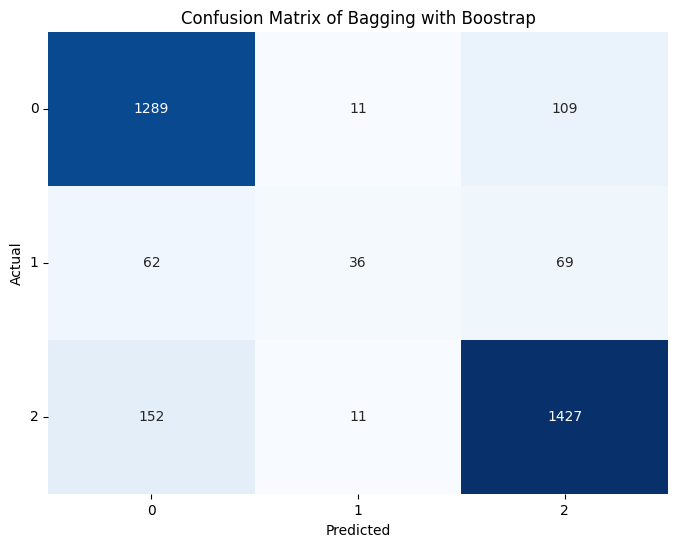

In [75]:
cm = confusion_matrix(y_test, pred)
labels = [0, 1, 2]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Bagging with Boostrap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()

# Without Boostrapping

In [59]:
bag_clf_ = BaggingClassifier(n_estimators=100, bootstrap=False, n_jobs=-1, random_state=seed)

In [60]:
bag_clf_

BaggingClassifier(bootstrap=False, n_estimators=100, n_jobs=-1,
                  random_state=221)

In [61]:
bag_clf_.fit(encoded_x_train, y_train)

BaggingClassifier(bootstrap=False, n_estimators=100, n_jobs=-1,
                  random_state=221)

In [62]:
pred_ = bag_clf_.predict(encoded_x_test)
pred_

array([2, 2, 2, ..., 2, 1, 2])

In [63]:
print(classification_report(y_test, pred_))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1409
           1       0.37      0.24      0.29       167
           2       0.89      0.88      0.88      1590

    accuracy                           0.85      3166
   macro avg       0.70      0.67      0.68      3166
weighted avg       0.84      0.85      0.85      3166



In [76]:
text_ = ["Giáo trình hay"]
x_ = tfidf.transform(text_)
bag_clf_.predict(x)

array([2])

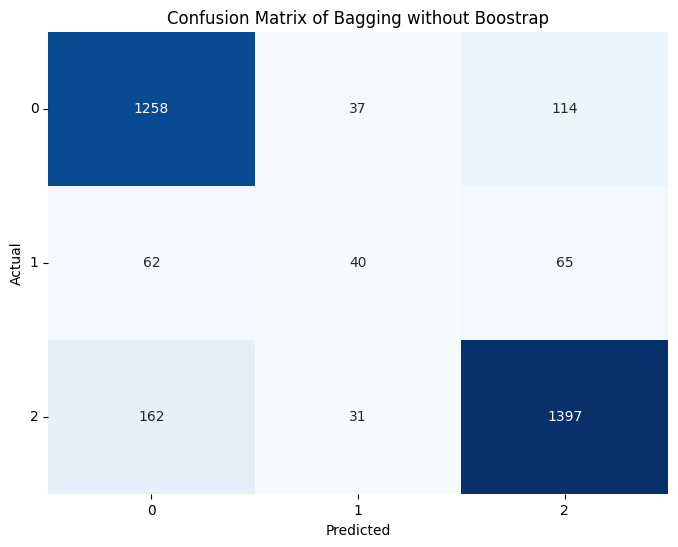

In [67]:

cm_ = confusion_matrix(y_test, pred_)
labels = [0, 1, 2]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Bagging without Boostrap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()